---
### Import libaries

In [1]:
import sys
import gc
import os
import pandas as pd
import umap
import umap.plot
from pynndescent import NNDescent
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/creditCardFraud/Feature_Visualization/scripts")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

### Import processed data and combine data together

In [4]:
train = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/TrainingData_normal.csv")
dev = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/DevData_normal.csv")
test = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/hold_outset_moreFraud.csv")

In [5]:
data = combine_df(train,dev,test,"Class")

In [6]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

----
### Select similar num of Class 0 and 1 for umap visualization

In [8]:
X, y = create_umapDF(data,"Class",100000,2020)

-----
### Create unsupervised feature map with just 2 components and default setting

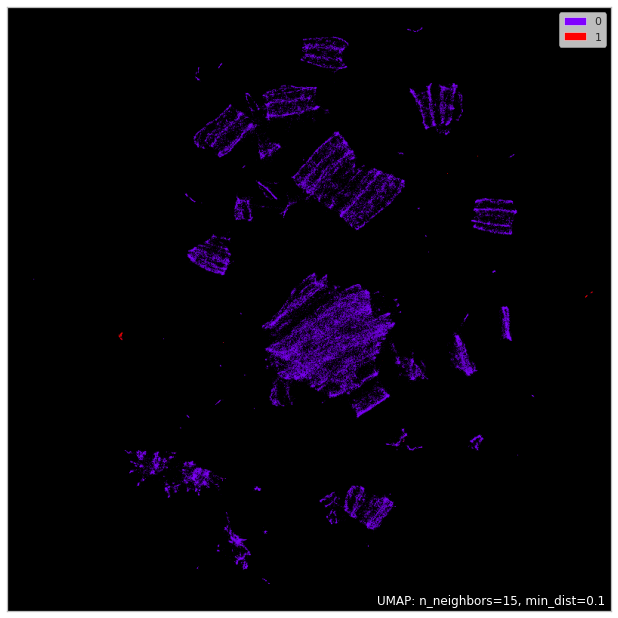

In [10]:
feature_map_un = umap.UMAP().fit(X)
umap.plot.points(feature_map_un, labels = y, theme = "fire")
plt.show()

### You can see decent separation between Fraud and normal transactions among many clusters
---

-----
### Create supervised feature map with just 2 components, default setting, and compare 

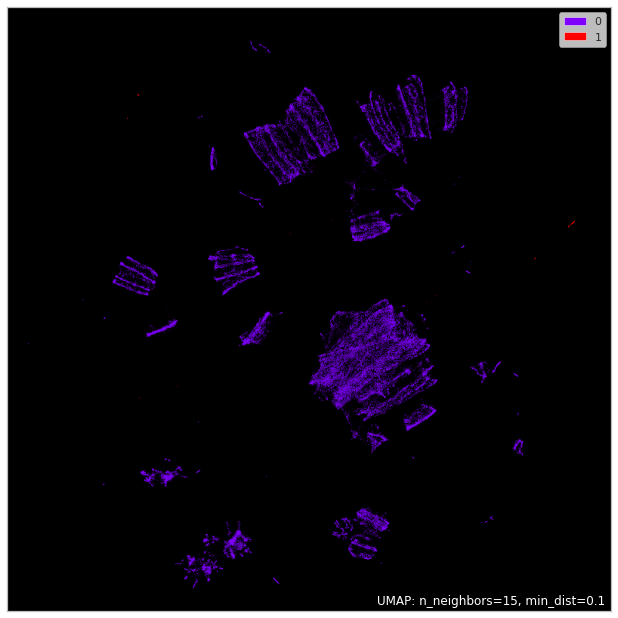

In [11]:
feature_map_su = umap.UMAP().fit(X,y)
umap.plot.points(feature_map_su, labels = y, theme = "fire")
plt.show()

### See similar level of separation among many clusters

### Garbage collect

In [12]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


### Now let's use both supervised and unsupervised embedding to transform the feature and look at the output

In [13]:
un_embed= feature_map_un.transform(X)

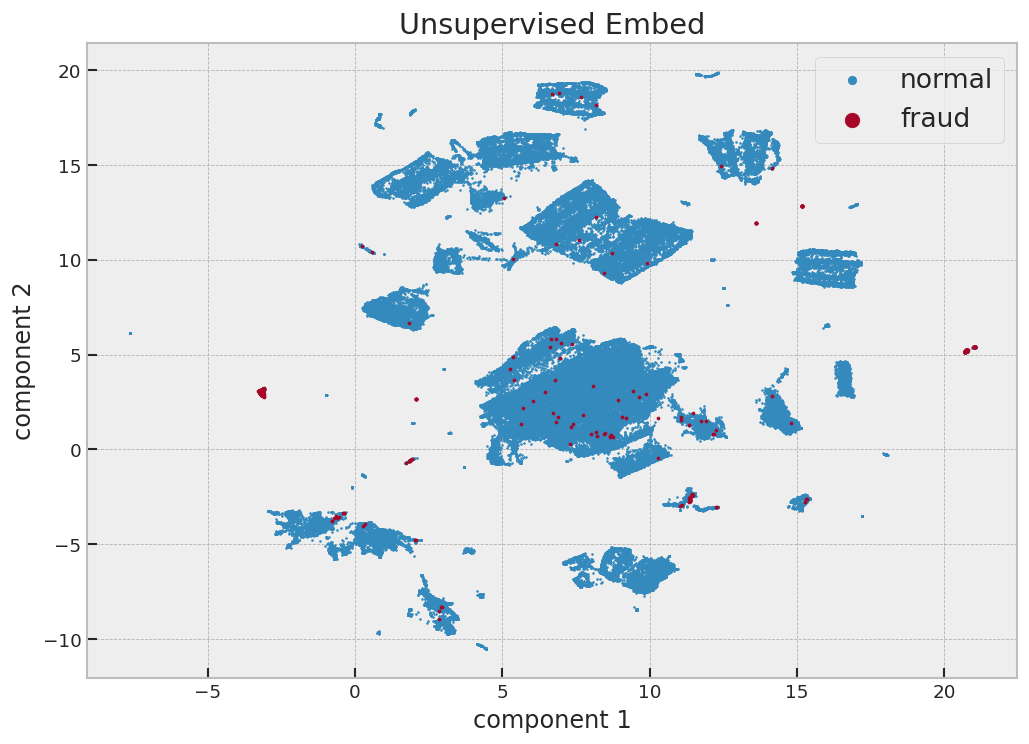

In [14]:
plot_umap(un_embed,y,"Unsupervised Embed")

In [15]:
su_embed = feature_map_su.transform(X)

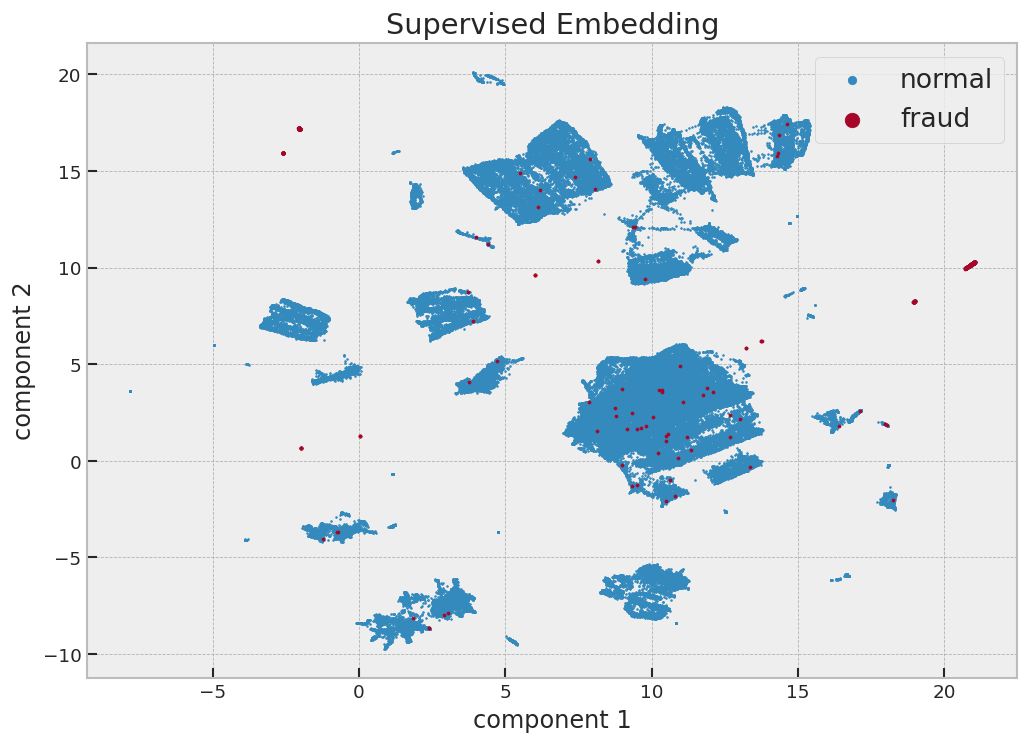

In [16]:
plot_umap(su_embed,y,"Supervised Embedding")

### Both some separation between fraud and normal

### Garbage collect again

In [17]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


---
### Let's Use Tree Forest Embedding along with UMAP:
   * Better improve feature extaction, a supervised model is used

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [19]:
tree = RandomForestClassifier(n_jobs=20)
preds = cross_val_predict(tree, X, y, cv=5)

In [20]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       0.95      0.82      0.88       492

    accuracy                           1.00    100492
   macro avg       0.97      0.91      0.94    100492
weighted avg       1.00      1.00      1.00    100492



### Now let's extract leave info for each observation and combine with UMAP

In [21]:
tree.fit(X,y)

RandomForestClassifier(n_jobs=20)

In [22]:
leaves = tree.apply(X)

In [23]:
print(leaves)  # leave assignment for reach sample 

[[208 193 212 ... 165 187 181]
 [208 193 212 ... 165 187 183]
 [204 196 212 ... 165 131 176]
 ...
 [ 11  31  20 ...  46   7  14]
 [ 11  31  26 ...   7   7  14]
 [ 11  25  26 ...   7   7  14]]


In [24]:
su_embed_tree = umap.UMAP(metric="hamming").fit_transform(leaves)

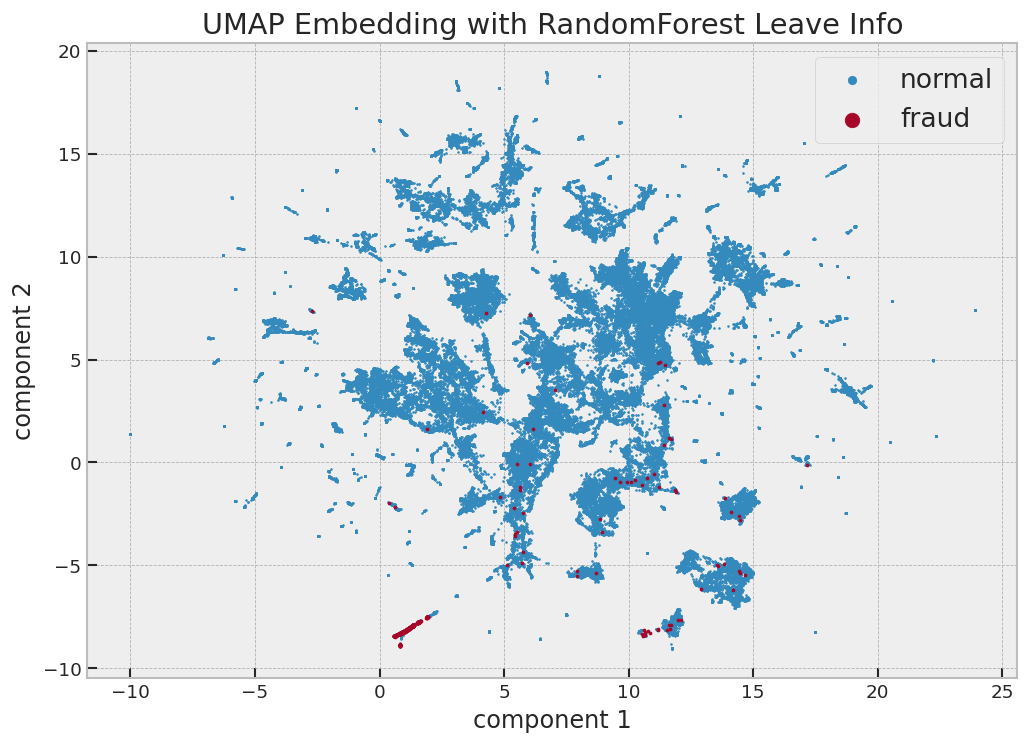

In [25]:
plot_umap(su_embed_tree,y,"UMAP Embedding with RandomForest Leave Info")

### Better separated with tree embed

### Garbage collect again

In [30]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


### Now let's check feature importances of the tree model 

In [36]:
importance_df = feature_importance(tree,X)
features = importance_df[:10]["feature_name"].tolist()
print(features)

['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V18', 'V9', 'V4', 'V7']


----
### Let's zoom in on the main red clusters and 1 blue clusters 

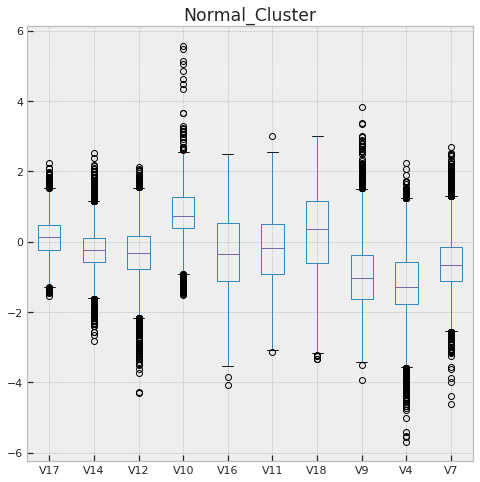

In [37]:
blue = map_analyses(su_embed_tree,0,5,2,10,y,"Normal_Cluster",X,features,0)

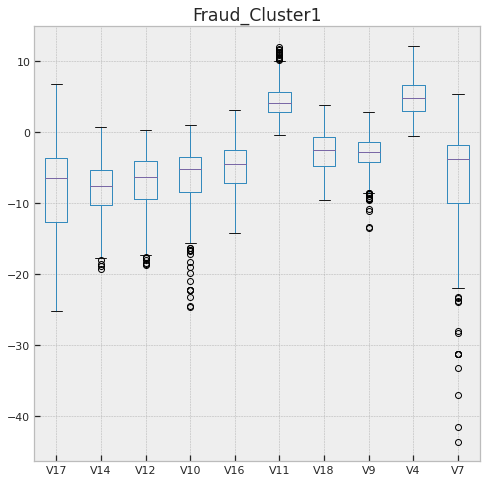

In [38]:
red = map_analyses(su_embed_tree,0,2,-9,-7,y,"Fraud_Cluster1",X,features,1)

### As you can see some feature distribution difference among these top 10 features and the UMAP clusters